In [26]:
#import keras
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

# Sentiment Analyse: Klassifikation von Film Reviews 
## Ein binäres Klassifikationsproblem

In diesem Notebook teilen wir Beispiele in positive und negative Filmreviews.

## IMDB Datensatz


Enthält 50,000 reviews von der Internet Movie Database. 
* 25,000 Trainingsbeispiele

* 25,000 Testbeispiele

mit jeweils 50% negative und 50% positive reviews.

Die Daten sind bereits vorbereitet: Die Reviews (Sequenzen von Wörtern) 
wurden in Sequenzen von ganzen Zahlen transformiert, wobei jede Zahl für ein bestimmtes Wort steht.

In [2]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

/home/mago1/anaconda3/envs/gfu/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/mago1/anaconda3/envs/gfu/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])



`num_words=10000` bedeutet, dass nur die top 10,000 häufigsten Wörter verwendet werden. Seltene Wörter werden nicht beachtet. 

In `train_data` und `test_data` sind Listen von reviews, jedes review ist eine Liste von Wort indices (und kodiert eine Sequenz von Wörtern). 
`train_labels` und `test_labels` sind Listen von 0s ubd 1s, wobei 0 für "negativ" und 1 für "positiv" steht.

In [3]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [5]:
train_labels

array([1, 0, 0, ..., 0, 1, 0])

Kein Index übersteigt 10,000:

In [6]:
max([max(sequence) for sequence in train_data])

9999

So kann man beispielsweise die Reviews enkodieren:

In [7]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [8]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## Vorbereitung der Daten


Listen von Zahlen lassen sich nicht in neuronales Netzwerk eingeben. Wir müssen die Listen in Tensoren umwandeln.
Eine Möglichkiet ist:

* One-hot-encoding: Wandle die Liste von Integers in Vektoren mit 0s und 1s. Concretely, d.h. in unserem Beispiel ein 10-dimensionaler Vektor. Jeder Eintrag des Vektors is entweder 1 oder 0, je nachdem ob der entsprechende Index in der Liste der Indizes vorkommt oder nicht.
z.B `[3, 5]` wird zu einem 10,000-dimensionalen Vektor mit Nullen außer an den Stellen 3 und 5, welche 1 sind.


In [9]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

In [11]:
x_train.shape

(25000, 10000)

In [12]:
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
y_test

array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)

## Netzwerk



![3-layer network](https://s3.amazonaws.com/book.keras.io/img/ch3/3_layer_network.png)

In [13]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [14]:
from keras import losses
from keras import metrics
from keras import optimizers

model.compile(
    optimizer=optimizers.RMSprop(lr=0.001),
    loss=losses.binary_crossentropy,
    metrics=[metrics.binary_accuracy]
)

In [15]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [16]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 2s 53ms/step - loss: 0.5353 - binary_accuracy: 0.7909 - val_loss: 0.4053 - val_binary_accuracy: 0.8708
Epoch 2/20
30/30 [==============================] - 1s 36ms/step - loss: 0.3247 - binary_accuracy: 0.8997 - val_loss: 0.3117 - val_binary_accuracy: 0.8889
Epoch 3/20
30/30 [==============================] - 1s 40ms/step - loss: 0.2362 - binary_accuracy: 0.9247 - val_loss: 0.2926 - val_binary_accuracy: 0.8856
Epoch 4/20
30/30 [==============================] - 1s 43ms/step - loss: 0.1857 - binary_accuracy: 0.9429 - val_loss: 0.2964 - val_binary_accuracy: 0.8787
Epoch 5/20
30/30 [==============================] - 1s 46ms/step - loss: 0.1538 - binary_accuracy: 0.9501 - val_loss: 0.2818 - val_binary_accuracy: 0.8883
Epoch 6/20
30/30 [==============================] - 1s 43ms/step - loss: 0.1266 - binary_accuracy: 0.9603 - val_loss: 0.3175 - val_binary_accuracy: 0.8795
Epoch 7/20
30/30 [==============================] - 1s 48ms/step - los

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

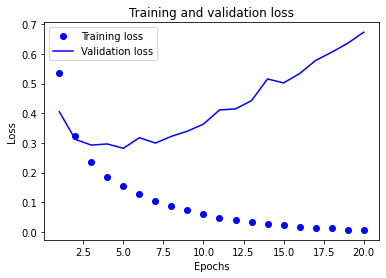

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

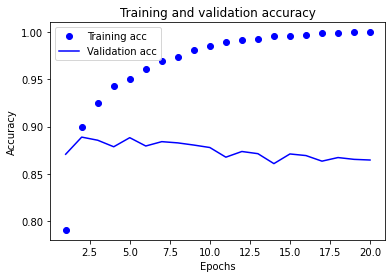

In [19]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [20]:
model = Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 1s 28ms/step - loss: 0.4687 - accuracy: 0.8244
Epoch 2/4
49/49 [==============================] - 1s 24ms/step - loss: 0.2676 - accuracy: 0.9075
Epoch 3/4
49/49 [==============================] - 1s 28ms/step - loss: 0.2040 - accuracy: 0.9275
Epoch 4/4
782/782 [==============================] - 22s 29ms/step - loss: 0.2897 - accuracy: 0.8856


In [21]:
results

[0.2896813750267029, 0.8855999708175659]

Accuracy = 88%

## Using a trained network to generate predictions on new data

In [23]:
model.predict(x_test[0:1])

array([[0.2482793]], dtype=float32)

## Übung 1:


* Wir haben 2 hidden layers benutzt. Nutze 1 oder 3 hidden layers und  validation and test accuracy.
* Ändere die Anzahl der Neurone pro Layer: 32, 64, ...
* Versuche die `mse` Lossfunktion anstatt von `binary_crossentropy`.
* Versuche die `tanh` Aktivierungsfunktion anstatt von relu zu verwenden `relu`.

# Übung 2:

In [40]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

In [43]:
np.max(train_labels)

45

Der Reuters-Datensatz ist ein Datensatz von Nachrichtenmeldungen, die sich in 46 verschiedene Themen einteilen lassen.

Eure Aufgabe ist es, analog zum IMDB-Datensatz ein Modell für die Klassifizierung der Reutersmeldungen zu trainieren.

* Schaut Euch eine dekodierte Meldung an.
* Vektorisiert die Daten und Targets
* Baut ein Modell: Vorsicht auf die Outputdimension = 46, activation nicht sigmoid sondern 'softmax', loss-function='sparse_categorical_crossentropy'
* Spaltet ein Validationset ab und benutzt es im Training
* Plottet Validation-Loss und Trainings-Loss um Overfitting zu diagnostizieren.
* Wenn Ihr mit Eurem Model glücklich seid --> Evaluiert es auf dem Testset.